In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


## Binary Classification Bank Churn using TensorFlow

**Objective**: Utilizing data on bank customer churn, forecast whether a customer retains their account or terminates it.

**Assessment**: The evaluation is conducted using the area under the ROC curve (AUC) to compare the predicted probabilities with the actual outcomes.

# About Data:

The bank customer churn dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be a customer. The dataset includes the following attributes:

1. Customer ID: A unique identifier for each customer
2. Surname: The customer's surname or last name
3. Credit Score: A numerical value representing the customer's credit score
4. Geography: The country where the customer resides (France, Spain or Germany)
5. Gender: The customer's gender (Male or Female)
6. Age: The customer's age.
7. Tenure: The number of years the customer has been with the bank
8. Balance: The customer's account balance
9. NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)
10. HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)
11. IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)
12. EstimatedSalary: The estimated salary of the customer
13. Exited: Whether the customer has churned (1 = yes, 0 = no)

## Import Libraries

In [4]:
# data manipulation
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style='whitegrid', palette='viridis')

# preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder 

# deep learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# path
import time
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

2024-07-14 08:11:27.010067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 08:11:27.010248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 08:11:27.191843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


## Upload Data

In [12]:
train = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")

In [13]:
print(train.shape, test.shape)
train

(165034, 14) (110023, 13)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0


# Preprocessing

In [14]:
train.drop(columns = ["id", "CustomerId", "Surname"], axis=1, inplace=True)
test.drop(columns = ["id", "CustomerId", "Surname"], axis=1, inplace=True)

In [15]:
def cleaned(df):
    # Encoding Categorical Features
    le = LabelEncoder()
    df['Geography'] = le.fit_transform(df['Geography'])
    df['Gender'] = le.fit_transform(df['Gender'])
    
    # Normalize Numerical Features
    num_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
    sc = StandardScaler()
    df[num_features] = sc.fit_transform(df[num_features])
    
    return df

train_preprocessed = cleaned(train)
test_preprocessed = cleaned(test)

In [16]:
train_preprocessed.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.144135,0,1,-0.578074,-0.719973,-0.883163,0.814298,0.571263,-0.99555,1.369486,0
1,-0.367706,0,1,-0.578074,-1.432694,-0.883163,0.814298,0.571263,1.00447,-1.254085,0
2,0.268974,0,1,0.211354,1.774548,-0.883163,0.814298,0.571263,-0.99555,1.437422,0
3,-0.941966,0,1,-0.465299,-1.076334,1.486918,-1.013348,0.571263,1.00447,-0.557018,0
4,0.743362,2,1,-0.578074,-0.007253,-0.883163,0.814298,0.571263,1.00447,-1.938770,0


# Correlation

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0.5, 0, 'CreditScore'),
  Text(1.5, 0, 'Geography'),
  Text(2.5, 0, 'Gender'),
  Text(3.5, 0, 'Age'),
  Text(4.5, 0, 'Tenure'),
  Text(5.5, 0, 'Balance'),
  Text(6.5, 0, 'NumOfProducts'),
  Text(7.5, 0, 'HasCrCard'),
  Text(8.5, 0, 'IsActiveMember'),
  Text(9.5, 0, 'EstimatedSalary'),
  Text(10.5, 0, 'Exited')])

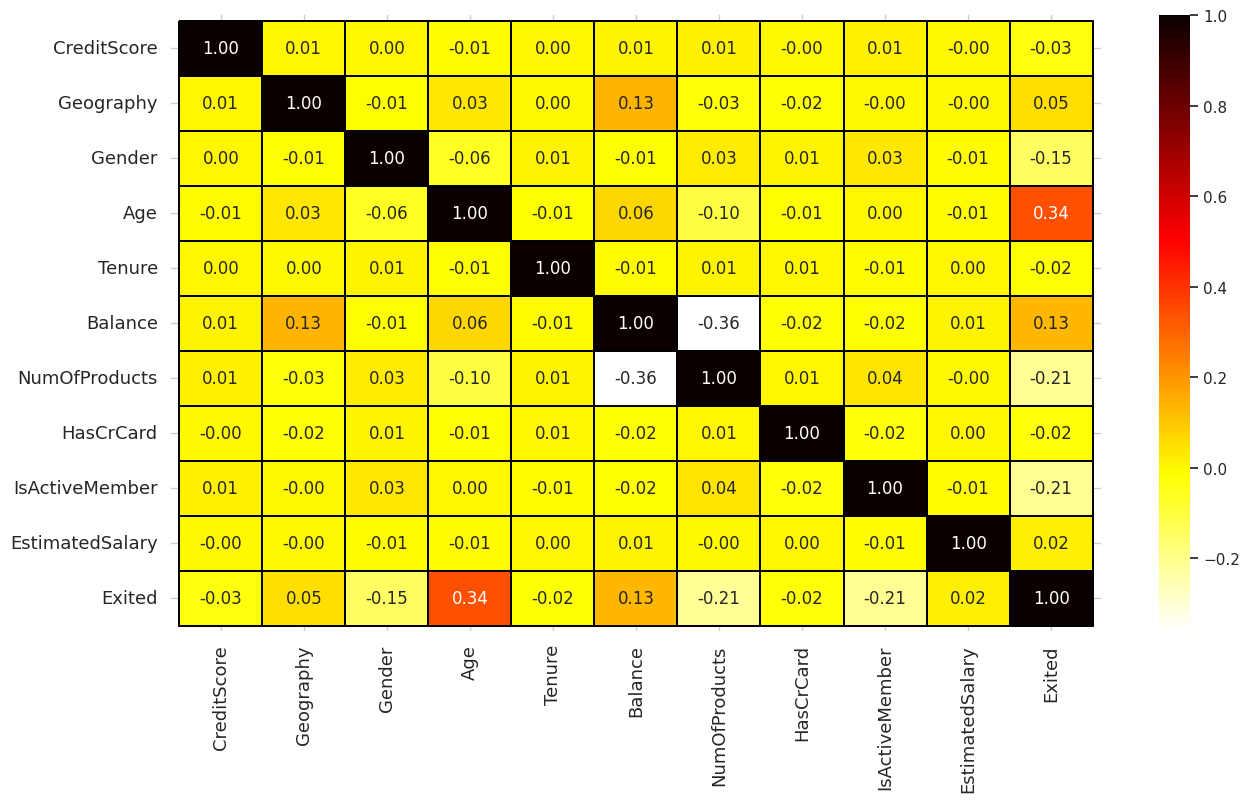

In [18]:
plt.figure(figsize = [15,8])
fig = sns.heatmap(train_preprocessed.corr(), cmap='hot_r',
                 annot=True, linecolor='black',linewidths=0.01, annot_kws={"fontsize":12}, fmt="0.2f")

top, bottom = fig.get_ylim()
fig.set_ylim(top+0.1,bottom-0.1)

left, right = fig.get_xlim()
fig.set_xlim(left-0.1,right+0.1) 

plt.yticks(fontsize=13,rotation=0)
plt.xticks(fontsize=13,rotation=90)

# Splitting Data X_train/y_train

In [19]:
X = train_preprocessed.drop(columns = "Exited", axis=1)
y = train_preprocessed['Exited']

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=42)

# Best Model Identidication

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [25]:
def auc_score(estimator, X_test, y_test):
    y_proba = estimator.predict_proba(X_test)
    final_auc_score = roc_auc_score(y_test, y_proba, average='macro', multi_class="ovr")
    return final_auc_score

XGboost Average AUC Score (Cross-Validation): 0.8866
Time taken for XGboost: 11.26 seconds
-------------------------
LightBM Average AUC Score (Cross-Validation): 0.8893
Time taken for LightBM: 15.15 seconds
-------------------------
CatBoost Average AUC Score (Cross-Validation): 0.8889
Time taken for CatBoost: 109.49 seconds
-------------------------
RandomForest Average AUC Score (Cross-Validation): 0.8735
Time taken for RandomForest: 156.29 seconds
-------------------------


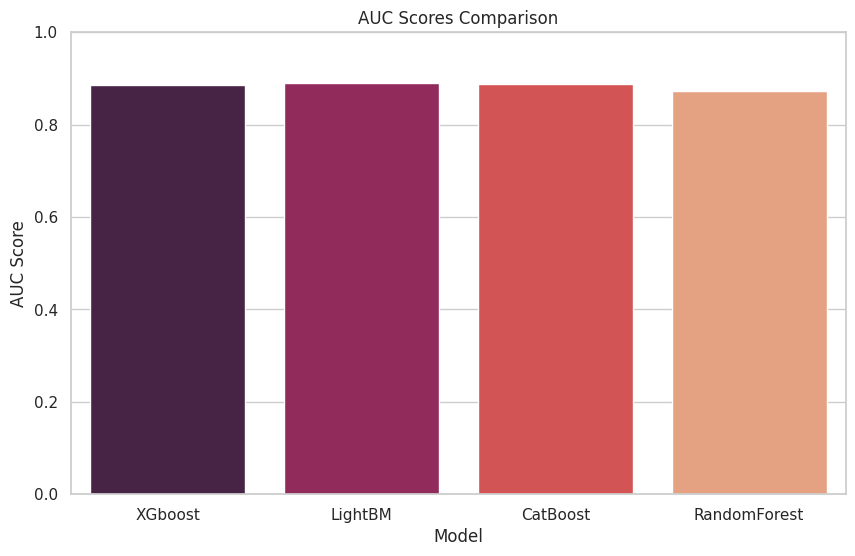

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Initialize models
xgb = XGBClassifier(objective='binary:logistic', random_state=42, verbosity=0)
lgbm = LGBMClassifier(random_state=42, verbosity=0)
cb = CatBoostClassifier(random_state=42, verbose=0)
rf = RandomForestClassifier(random_state=42, verbose=0)

# List of models
models = [('XGboost', xgb), ('LightBM', lgbm), ('CatBoost', cb), ('RandomForest', rf)]

# Dictionary to store AUC scores
auc_scores = {'Model': [], 'AUC Score': []}

# Perform cross-validation and collect results
for name, model in models:
    startTime = time.time()
    cv_auc_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
    avg_auc_score = np.mean(cv_auc_scores)
    endTime = time.time() - startTime
    
    # Store results in dictionary
    auc_scores['Model'].append(name)
    auc_scores['AUC Score'].append(avg_auc_score)
    
    # Print and display results
    print(f'{name} Average AUC Score (Cross-Validation): {avg_auc_score:.4f}')
    print(f'Time taken for {name}: {endTime:.2f} seconds')
    print('-' * 25)

# Create DataFrame from results
auc_df = pd.DataFrame(auc_scores)

# Plotting AUC scores comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='AUC Score', data=auc_df, palette='rocket')
plt.title('AUC Scores Comparison')
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.ylim(0, 1)  # Limit y-axis from 0 to 1 for AUC score
plt.show()


# OPTUNA FOR LIGHTBM

In [40]:
import optuna
from lightgbm import LGBMClassifier
from sklearn import metrics

def lgb_objective(trial):
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'random_state': 4197
    }
    
    model = LGBMClassifier(n_estimators=1000, **param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    
    test_pred = model.predict_proba(X_test)[:, 1]
    auc_score = metrics.roc_auc_score(y_test, test_pred)
    
    return auc_score

# Assuming X_train, X_test, y_train, y_test are defined
lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(lgb_objective, n_trials=150, n_jobs=-1)



[I 2024-07-14 09:35:06,628] A new study created in memory with name: no-name-81c05192-bda1-410a-824d-638bf84e6617
[I 2024-07-14 09:36:01,915] Trial 0 finished with value: 0.8681208972378344 and parameters: {'lambda_l1': 0.00021768428180354813, 'lambda_l2': 3.33151625453149e-08, 'num_leaves': 101, 'feature_fraction': 0.4813922314416961, 'bagging_fraction': 0.36633535048716537, 'bagging_freq': 7, 'min_child_samples': 71}. Best is trial 0 with value: 0.8681208972378344.
[I 2024-07-14 09:36:04,795] Trial 3 finished with value: 0.8698694990892496 and parameters: {'lambda_l1': 0.0001054138073642295, 'lambda_l2': 0.06836207778890928, 'num_leaves': 124, 'feature_fraction': 0.4973853821832574, 'bagging_fraction': 0.5758403713084506, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 3 with value: 0.8698694990892496.
[I 2024-07-14 09:36:07,052] Trial 2 finished with value: 0.859281852131952 and parameters: {'lambda_l1': 0.15432262301933058, 'lambda_l2': 0.2269155528088892, 'num_leaves': 

In [44]:
best_params = lgbm_study.best_params
best_params["random_state"]=4197
best_params


{'lambda_l1': 0.1351334584441638,
 'lambda_l2': 0.008518478193846758,
 'num_leaves': 6,
 'feature_fraction': 0.7048063854418845,
 'bagging_fraction': 0.9418515001526175,
 'bagging_freq': 1,
 'min_child_samples': 57,
 'random_state': 4197}

In [46]:
best_score = lgbm_study.best_value
best_score

0.890049720973327

In [48]:
lgbm_mod = LGBMClassifier(**best_params)
lgbm_mod.fit(X_train, y_train)


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7048063854418845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048063854418845
[LightGBM] [Warning] lambda_l2 is set=0.008518478193846758, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008518478193846758
[LightGBM] [Warning] lambda_l1 is set=0.1351334584441638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1351334584441638
[LightGBM] [Warning] bagging_fraction is set=0.9418515001526175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9418515001526175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7048063854418845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048063854418845
[LightGBM] [Warning] lambda_l2 is set=0.008518478193846758

In [49]:
lgbm_train_pred = lgbm_mod.predict_proba(X_train)[:, 1]
lgbm_test_pred = lgbm_mod.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7048063854418845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048063854418845
[LightGBM] [Warning] lambda_l2 is set=0.008518478193846758, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008518478193846758
[LightGBM] [Warning] lambda_l1 is set=0.1351334584441638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1351334584441638
[LightGBM] [Warning] bagging_fraction is set=0.9418515001526175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9418515001526175
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7048063854418845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048063854418845
[LightGBM] [Warning] lambda_l2 is set=0.008518478193846758

In [50]:
train_auc = roc_auc_score(y_train, lgbm_train_pred)
test_auc = roc_auc_score(y_test, lgbm_test_pred)

print(f"Train ROC AUC: {train_auc:.4f}")
print(f"Test ROC AUC: {test_auc:.4f}")

Train ROC AUC: 0.8882
Test ROC AUC: 0.8880


# MODEL PERFORMANCE

In [52]:
print(f'LGBM Best Model Performance--> Train Accuracy:{train_auc} | Test Accuracy:{test_auc}')

LGBM Best Model Performance--> Train Accuracy:0.8882030438819336 | Test Accuracy:0.8879541074973814


# FEATURE IMPORATNCE

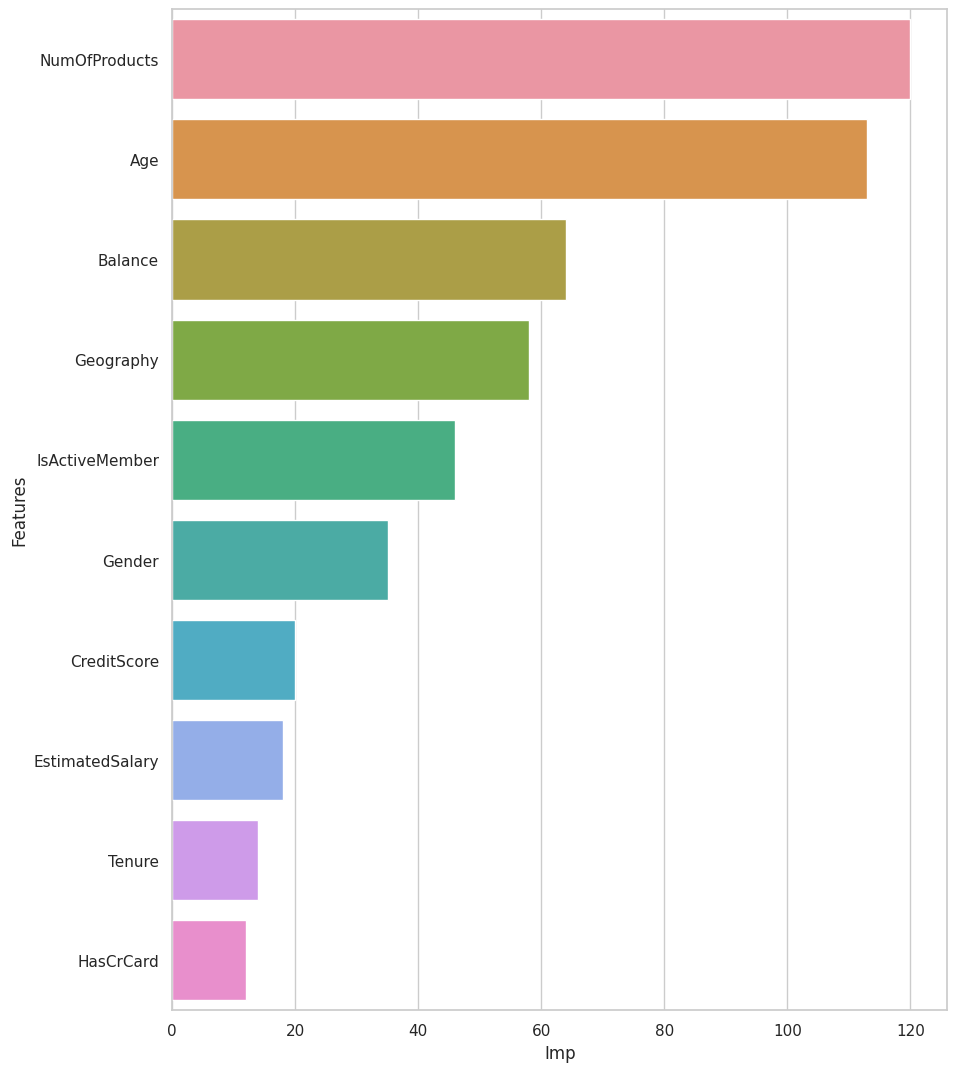

In [53]:
plt.figure(figsize=(10,13))
lgbm_mod_imp_fet=pd.DataFrame({'Features':X_train.columns, 'Imp':lgbm_mod.feature_importances_.round(2)})
lgbm_mod_imp_fet=lgbm_mod_imp_fet.sort_values(by='Imp',ascending=False)
sns.barplot(y=lgbm_mod_imp_fet['Features'],x=lgbm_mod_imp_fet['Imp'])
plt.show()

# SUBMITTING

In [56]:
test_preprocessed

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,-0.878176,0,0,-1.706504,-1.067887,-0.881274,0.820030,-1.746219,1.009580,0.967874
1,0.329567,0,0,0.888990,-1.067887,-0.881274,-1.015806,0.572666,-0.990511,-0.790939
2,-0.006609,0,0,-0.465181,0.713922,-0.881274,0.820030,0.572666,-0.990511,0.528413
3,0.304665,0,1,-0.239486,1.070284,-0.881274,-1.015806,0.572666,-0.990511,0.032150
4,1.188684,1,1,-0.013791,1.783008,1.050038,-1.015806,0.572666,-0.990511,0.539331
...,...,...,...,...,...,...,...,...,...,...
110018,-1.077392,2,1,-1.029419,0.713922,0.967796,-1.015806,0.572666,1.009580,0.711510
110019,-1.015137,0,0,-0.239486,-0.355164,1.954171,-1.015806,0.572666,1.009580,-1.394946
110020,0.690645,0,1,-0.803724,-1.067887,-0.881274,0.820030,0.572666,-0.990511,-1.909981
110021,0.653292,0,0,-0.690876,-0.711526,-0.881274,-1.015806,0.572666,1.009580,0.924908


In [57]:
sample_df = pd.read_csv("/kaggle/input/playground-series-s4e1/sample_submission.csv")
sample_df

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5
...,...,...
110018,275052,0.5
110019,275053,0.5
110020,275054,0.5
110021,275055,0.5


In [59]:
ids = test_preprocessed.index
ids

RangeIndex(start=0, stop=110023, step=1)

In [60]:
test_predictions = lgbm_mod.predict_proba(test_preprocessed)[:, 1]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7048063854418845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048063854418845
[LightGBM] [Warning] lambda_l2 is set=0.008518478193846758, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008518478193846758
[LightGBM] [Warning] lambda_l1 is set=0.1351334584441638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1351334584441638
[LightGBM] [Warning] bagging_fraction is set=0.9418515001526175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9418515001526175


In [61]:
results_df = pd.DataFrame({
    'id': ids,
    'Exited': test_predictions
})

In [62]:
results_df

,id,Exited
0,0,0.024730
1,1,0.793243
2,2,0.038494
3,3,0.255915
4,4,0.337835
...,...,...
110018,110018,0.057799
110019,110019,0.092082
110020,110020,0.021348
110021,110021,0.155313


In [63]:
results_df.to_csv('model_results.csv', index=False)